# Homework Optimization for Data Science 2023/2024

**MULTI-CLASS LOGISTIC REGRESSION**

Consider a multi-class logistic problem of the form:
$$\tag{1} \min_{X \in \mathbb{R}^{d \times k}} \sum_{i=1}^{m} \left[ -x_{b_i}^T a_i + log\left( \sum_{c=1}^{k} \exp(x_{c}^T a_i) \right) \right] $$


Likelihood for single training example $i$ with features $a_i \in \mathbb{R}^{d}$ and label $b_i \in \{1, 2, \ldots, k\}$ is given by

$$ \tag{2} P(b_i | a_i, X) = \frac{\exp(x_{b_i}^T a_i)}{\sum_{c=1}^k \exp(x_c^T a_i)}$$

where $x_c$ is column $c$ of matrix parameter $X \in \mathbb{R}^{d \times k}$ to maximize likelihood over $m$ i.i.d. training samples.
We minimize negative log-likelihood:

$$ \tag{3}f(X) = \sum_{i=1}^{m} \left[ -x_{b_i}^T a_i + log\left( \sum_{c=1}^{k} \exp(x_{c}^T a_i) \right) \right]$$ 

Partial derivative is:

$$ \tag{4}\frac{\partial f(X)}{\partial x_{jc}} = - \sum_{i=1}^{m} a_{ij} \left[ I(b_i = c) - \frac{\exp(x^T_{c} {a}_i)}{\sum_{c'=1}^{k} \exp({x^T _{c'}} {a}_{i})}\right] $$



**HOMEWORK**

1. Randomly generate a $1000 \times 1000$ matrix with entries from a $\mathcal{N}(0,1)$.
2. Generate $b_i \in \{1, 2, \ldots, k\}$ with $k = 50$ by computing $AX + E$ with $X \in \mathbb{R}^{d \times k}$, $E \in \mathbb{R}^{m \times k}$ sampled from normal distribution and consider max index row as class label.
3. Solve problem $(1)$ with:
    * *Gradient Descent*.
    * *BCDG with Randomized rule*.
    * *BCDG with Gauss-Southwell rule*.
4. Choose a pubicly available dataset and test methods on this.
5. Analyze *Accuracy vs CPU Time*.
6. Describe what you did on a PDF file.
7. Submit project.
    

In [1]:
# Import the necessary libraries
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo 
from sklearn.metrics import accuracy_score




# Set the random seed for reproducibility
seed = 13
random.seed(seed)
np.random.seed(seed)

## 1. Toy Dataset

Initialize the input matrix $A$, features matrix $X$, and error matrix $E$ with random values from a standard normal distribution  $\mathcal{N}(0,1)$.

In [2]:
# Set the dimensions of the input data
m = 1000
d = 1000

# Set the number of labels
k = 50

### 1.1. Input $A$

$A \in \mathbb{R}^{m \times d}$

In [3]:
# Generate the input matrix
A = np.random.randn(m, d)

# Print the shapes of the matrice
print('Shape of A:', A.shape)           # A is of shape (m, d)

Shape of A: (1000, 1000)


### 1.2. Features $X$

$X \in \mathbb{R}^{d \times k}$

In [4]:
# Generate the features matrix
X = np.random.randn(d, k)

# Print the shapes of the matrice
print('Shape of X:', X.shape)          # X is of shape (d, k)

Shape of X: (1000, 50)


### 1.3. Error $E$

$E \in \mathbb{R}^{m \times k}$

In [5]:
# Generate the error matrix
E = np.random.randn(m, k)

# Print the shapes of the matrice
print('Shape of E:', E.shape)         # E is of shape (m, k)

Shape of E: (1000, 50)


### 1.4. Labels $B$

$B \in \mathbb{R}^{m}$,   $b_i \in \{1, 2, \ldots, k\} \quad \text{with} \quad k = 50$


In [6]:
# Generate the output matrix Y
Y = A @ X + E

# Get the index of the maximum value in each row
B = np.argmax(Y, axis=1) + 1         # Add 1 to the index to get the actual value (1-based index)

# Print B min and max values
print('Min value of B:', np.min(B))  # B contains values between 1 and k
print('Max value of B:', np.max(B))

# Print the shapes of the matrices
print('Shape of Y:', Y.shape)         # Y is of shape (m, k)
print('Shape of B:', B.shape)         # B is of shape (m,)

Min value of B: 1
Max value of B: 50
Shape of Y: (1000, 50)
Shape of B: (1000,)


### 1.5. Starting Point

In [7]:
# Set the new starting point with Xavier Initialization
X_train = np.random.randn(d, k) * np.sqrt(1 / d)

### 1.6. Lipschitz Constant
Upper bound for Lipschitz Constant $L$:
$$ L \leq \|A\|_2 \|A\|_F $$

Check the report for proof.

In [8]:
def Lipschitz_constant(A):
    L = np.linalg.norm(A, 2) * np.linalg.norm(A, 'fro')
    return L

### 1.7. Hyperparameters


In [9]:
# Set the learning rate
alpha = 1 / Lipschitz_constant(A)

# Set the number of iterations
num_iterations = 2000

# Set the tolerance
epsilon = 1e-6

# Set th number of blocks
j = k                                # each column of X is a block

## 2. Cost Function

Compute the cost function: $$ \sum_{i=1}^{m} \left[ -x_{bi}^T a_i + log\left( \sum_{c=1}^{k} \exp(x_{c}^T a_i) \right) \right] $$


### 2.1. One-Hot Encoding matrix $H$

In [10]:
# One-hot encoding the vector B
H = pd.get_dummies(B).astype(float)   # One-hot encoding the vector B

# Transform the DataFrame into a numpy array
H = H.values

# Print the shapes of the matrice
print('Shape of H:', H.shape)       # H is of shape (m, k)

Shape of H: (1000, 50)


### 2.2. Helper vector $M$ and $K$

We compute this helper vector to vectorize $\sum_{i=1}^{m}$ and $\sum_{c=1}^{k}$.

In [11]:
# Compute a row vetor of ones
M = np.ones((1, m))

# Compute a column vector of ones
K = np.ones((k, 1))

### 2.3. Vectorized Cost Function

Vectorized version of the cost function $f(X)$:
$$\tag{5}1_m^T \left[ - \text{diag}(AXH^T) + \log\left( \exp(AX) \cdot 1_k \right) \right]$$

Check the report for proof.

In [12]:
## Compute the vectorized cost function
def compute_cost(X, A, H, M, K):

    # Compute the exponential of AX
    exp_AX = np.exp(A @ X)

    # Compute the log of the exponential of AX
    log = np.log(exp_AX @ K)

    # Compute the diagonal of the matrix product
    diag = np.diag((A @ X) @ H.T)[:, np.newaxis]
    
    # Compute the cost
    cost = M @ (- diag + log)
    
    return cost.item()

# Compute the gradient of the cost function
cost = compute_cost(X, A, H, M, K)

# Print the cost

print('Cost:', cost)

Cost: 101.972384520606


### 2.4. Softmax Function

The softmax function is the equation $(2)$.

In [13]:
# Compute the softmax function
def softmax(matrix):
    # Exponentiate the shift matrix
    exps = np.exp(matrix)

    # Compute the softmax matrix
    softmax_matrix = exps / np.sum(exps, axis=0, keepdims=True)

    return softmax_matrix


### 2.5. Accuracy Function

$$\text{Accuracy} = \frac{\text{Numero di predizioni corrette}}{\text{Numero totale di predizioni}}=\frac{TP + TN}{TP + TN + FP + FN} $$

In [14]:
# Compute the accuracy function
def compute_accuracy(X, A, B, index_0=True):

    # Compute the softmax of the matrix product
    Y_pred = softmax(A @ X)

    if index_0 == True:
        # Get the index of the maximum value in each row
        B_pred = np.argmax(Y_pred, axis=1)

    else:
        # Get the index of the maximum value in each row
        B_pred = np.argmax(Y_pred, axis=1) + 1

    # Compute the accuracy of the model
    accuracy = accuracy_score(B, B_pred)

    return accuracy


## 3. Derivative

### 3.1. Gradient function

Vectorized version of the derivative of $f(X)$ with respect to $X$ : $$\tag{6}\frac{\partial f(X)}{\partial X} = -A^T (H - \exp(AX) \circ C)$$

with $C = (\frac{1}{\exp(AX) 1_K}, \dots,  \frac{1}{\exp(AX) 1_K}), C \in \mathbb{R}^{m \times k}$

Check the report for proof.

In [15]:
# Compute the vectorized derivative of the loss function with respect to X
def gradient(X, A, H, K):

    # Compute the exponential of A @ X
    exp_AX = np.exp(A @ X)

    # Compute the derivative of the loss function with respect to X
    df_dX = - A.T @ (H - (exp_AX * (1 / (exp_AX @ K))))  # Perform broadcasting between exp_AX and (1 / (exp_AX @ I)) instead of compting the C matrix
    
    return df_dX

### 3.2. Gradient function of a block

Vectorized version of the derivative of $f(X)$ with respect to $X_c$: 
$$\tag{7}\frac{\partial f(X)}{\partial X_c} = -A^T \left( H_c - \exp(AX_c)  \circ \frac{1}{\exp(AX) 1_K}\right)
 $$

Check the report for proof.

In [16]:
# Compute the vectorized derivative of the loss function with respect to a single column of X
def gradient_block(X, A, H, K, index):

        # Select the index-th column of X
        X_c = X[:, index:index+1]
        
        # Compute the exponential of A @ X
        exp_AX = np.exp(A @ X)

        # Compute the exponential of A @ X for the index-th column
        exp_AX_c = np.exp(A @ X_c)

        # Select the index-th column of the one-hot matrix
        H_c = H[:, index:index+1]

        # Compute the derivative of the loss function with respect to X
        df_dX_c = - A.T @ (H_c - (exp_AX_c * (1 / (exp_AX @ K))))  # Perform broadcasting between exp_AX and (1 / (exp_AX @ I))

        return df_dX_c

## 4. Gradient Descent method

Update rule: $$\tag{8}X_{i+1} = X_i - \alpha \cdot \frac{\partial f(X)}{\partial X}$$

### 4.1. Algorithm

In [17]:
# Gradient Descent


def gradient_descent(X, A, H, K, alpha, num_iterations, epsilon):

    # Store the history of the norm, time and update to visualize the convergence
    norm_history = []
    time_history = []
    update_history = []

    # Compute the gradient of the loss function with respect to X
    grad = gradient(X, A, H, K)

    # Initialize the iteration
    i = 0

    # Loop for a number of iterations
    while i < num_iterations and np.linalg.norm(grad) > epsilon:
        

        ## Step 1: start the timer
        start = time.time()

        ## Step 2: update the parameters
        X = X - alpha * grad

        ## Step 3: update the gradient of the loss function with respect to the new X
        grad = gradient(X, A, H, K)
       
        ## Step 4: end the timer    
        end = time.time()

        ## Step 5: save the time to the history
        time_history.append(end - start)

        ## Step 6: save the norm to the history
        norm_history.append(np.linalg.norm(grad)) 

        ## Step 7: store the current X
        update_history.append(X)    

        ## Step 8: update the iteration
        i += 1
        
    return X, norm_history, time_history, update_history


# Run the gradient descent algorithm
X_GD, norm_history_GD, time_history_GD, update_history_GD = gradient_descent(X_train, A, H, K, alpha, num_iterations, epsilon)

# Print the accuracy on the training set
accuracy = compute_accuracy(X_GD, A, B, False)
print('Accuracy on the training set:', accuracy * 100, '%')

Accuracy on the training set: 100.0 %


In [18]:
# Compute the cost history
cost_history_GD = [compute_cost(X, A, H, M, K) for X in update_history_GD]

In [19]:
# Compute the accuracy history
accuracy_history_GD = [compute_accuracy(X, A, B, False) for X in update_history_GD]

### 4.2. Visualization

#### 4.2.1. Convergence

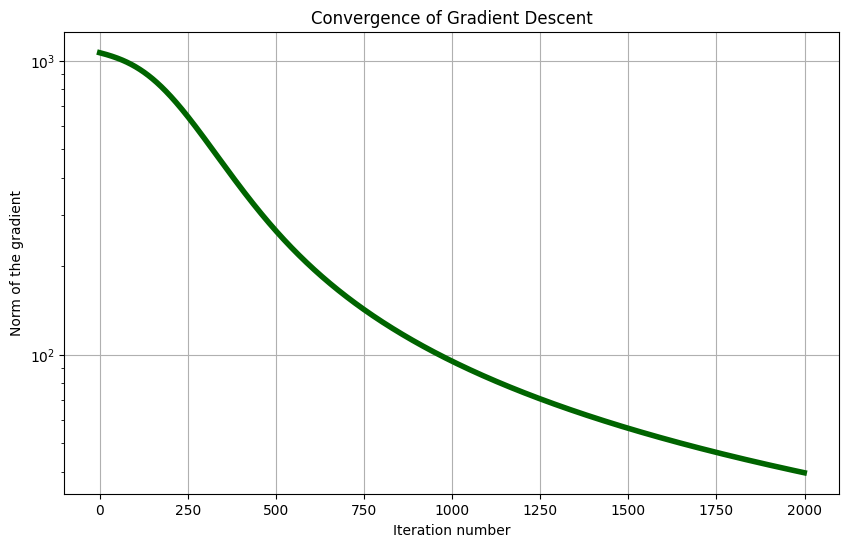

In [20]:
# Plot the convergence of the gradient descent algorithm with respect to the number of iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(norm_history_GD)), norm_history_GD, 'darkgreen', linewidth=4, label='Gradient Descent')
plt.grid()
plt.title("Convergence of Gradient Descent")
plt.xlabel("Iteration number")
plt.ylabel("Norm of the gradient")
plt.yscale('log')
plt.show()

#### 4.2.2. Accuracy

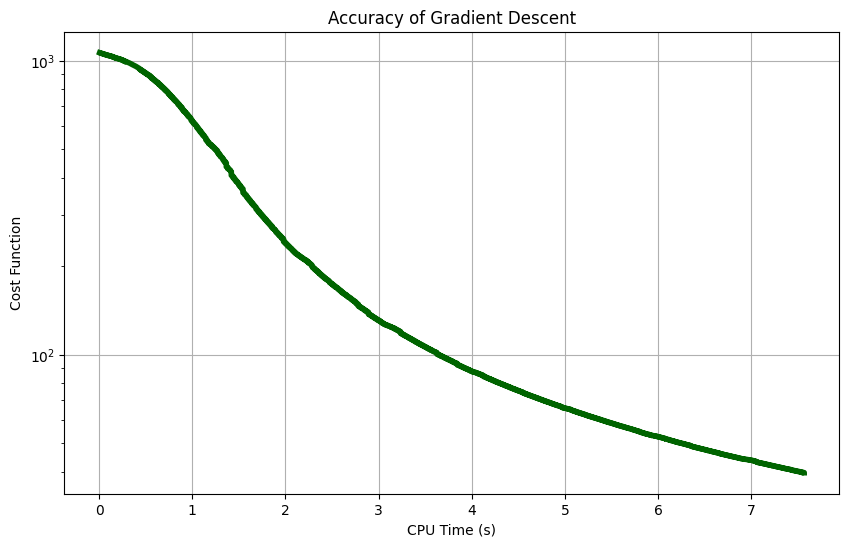

In [21]:
# Plot the cost function with respect to the CPU time
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_GD), norm_history_GD, 'darkgreen', linewidth=4, label='Gradient Descent')
plt.grid()
plt.title("Accuracy of Gradient Descent")
plt.xlabel("CPU Time (s)")
plt.ylabel("Cost Function")
plt.yscale('log')
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_15300\1497550425.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


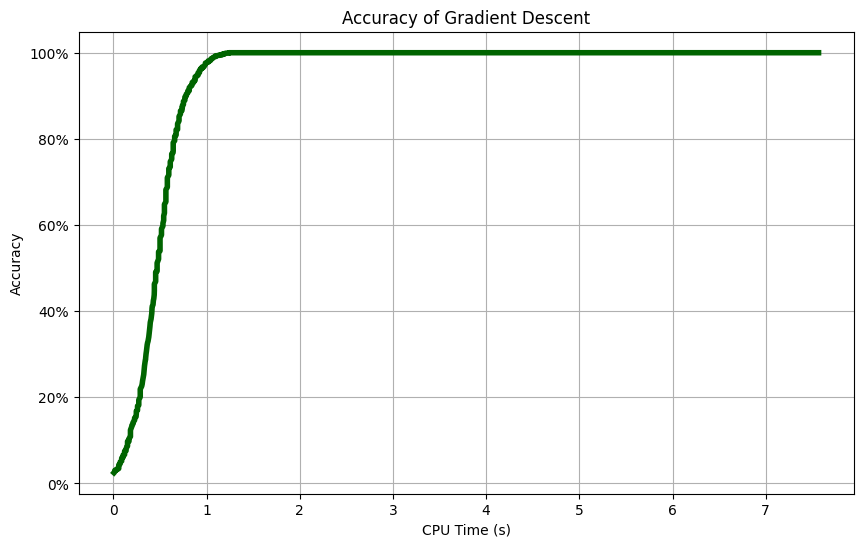

In [22]:
# Plot the accuracy of the model with respect to the CPU time
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_GD), accuracy_history_GD, 'darkgreen', linewidth=4, label='Gradient Descent')
plt.grid()
plt.title("Accuracy of Gradient Descent")
plt.xlabel("CPU Time (s)")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.show()

## 5. BCGD with Randomized rule



### 5.1. Algorithm

In [23]:
# BCGD with Randomized rule


def BCDG_randomized(X, A, H, K, alpha, num_iterations, epsilon, j):

    # Store the history of the norm, time and cost to visualize the convergence
    norm_history = []
    time_history = []
    update_history = []

    # Compute the gradient of the loss function with respect to X
    grad = gradient(X, A, H, K)

    # Initialize the iteration
    i = 0

    # Loop for a number of iterations
    while i < num_iterations and np.linalg.norm(grad) > epsilon:

        ## Step 1: start the timer
        start = time.time()

        ## Step 2: randomly select a block
        rand_index = np.random.randint(0, j)          # randomly select a block

        ## Step 3: set the block of the gradient
        random_gradient_block = grad[:, rand_index:rand_index+1]


        ## Step 5: compute the gradient of the block
        random_gradient_block_new = gradient_block(X, A, H, K, rand_index)

        ## Step 6: update the block
        grad[:, rand_index:rand_index+1] = random_gradient_block_new

        ## Step 7: update the parameters
        X = X - alpha * grad
       
        ## Step 8: end the timer
        end = time.time()

        ## Step 9: save the time to the history
        time_history.append(end - start)

        ## Step 10: save the norm to the history
        norm_history.append(np.linalg.norm(grad))     

        ## Step 11: store the current X
        update_history.append(X)

        ## Step 12: update the iteration
        i += 1 
        
    return X, norm_history, time_history, update_history

# Run the BCDG algorithm
X_BCGD_R, norm_history_BCGD_R, time_history_BCGD_R, update_history_BCGD_R = BCDG_randomized(X_train, A, H, K, alpha, num_iterations, epsilon, j)

# Print the accuracy on the training set
accuracy = compute_accuracy(X_BCGD_R, A, B, False)
print('Accuracy on the training set:', accuracy * 100, '%')

Accuracy on the training set: 100.0 %


In [24]:
# Compute the cost history
cost_history_BCDG_R = [compute_cost(X, A, H, M, K) for X in update_history_BCGD_R]

In [25]:
# Compute the accuracy history
accuracy_history_BCDG_R = [compute_accuracy(X, A, B, False) for X in update_history_BCGD_R]

### 5.2. Visualization

#### 5.2.1. Convergence

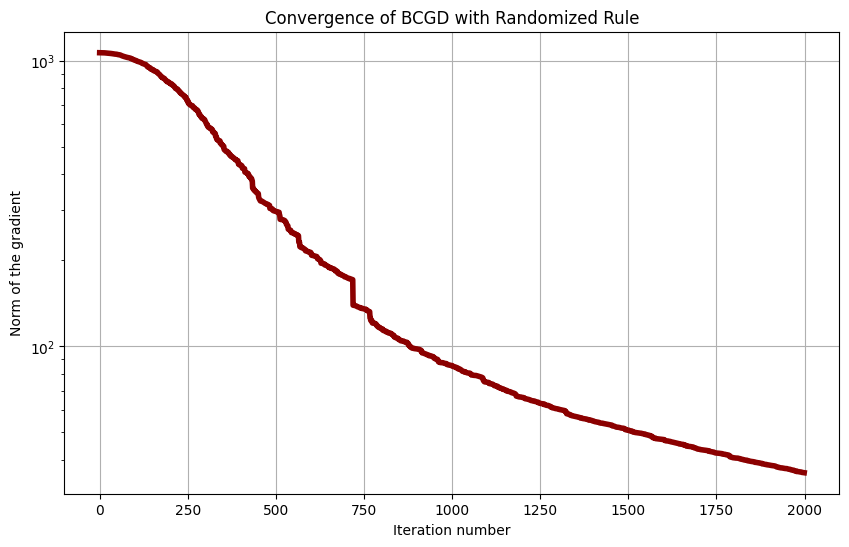

In [26]:
# Plot the convergence of the BCGD algorithm with respect to the number of iterations
plt.figure(figsize=(10, 6))  # Increase figure size
plt.plot(range(len(norm_history_BCGD_R)), norm_history_BCGD_R, 'darkred', linewidth=4, label='BCGD Randomized')
plt.grid()
plt.title("Convergence of BCGD with Randomized Rule")
plt.xlabel("Iteration number")
plt.ylabel("Norm of the gradient")
plt.yscale('log')
plt.show()


#### 5.2.2. Accuracy

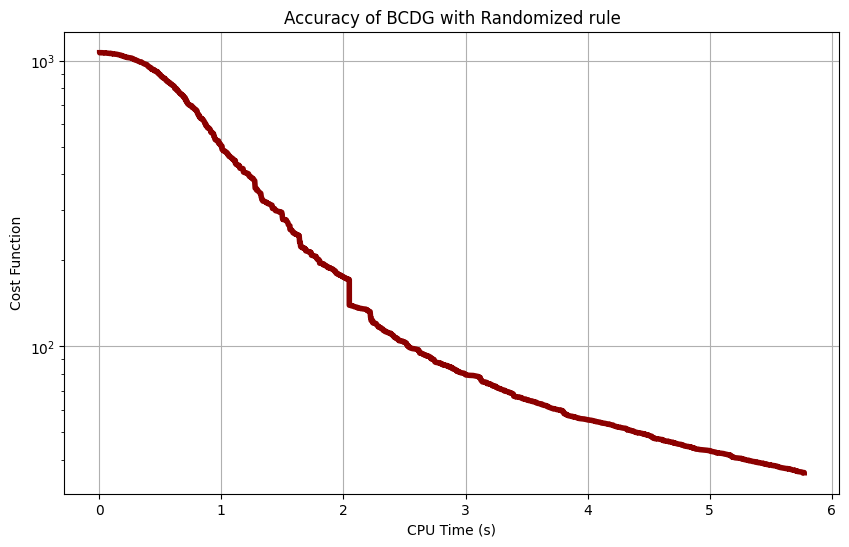

In [27]:
# Plot the cost function with respect to the CPU time
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_BCGD_R), norm_history_BCGD_R, 'darkred', linewidth=4, label='BCGD Randomized')
plt.grid()
plt.title("Accuracy of BCDG with Randomized rule")
plt.xlabel("CPU Time (s)")
plt.ylabel("Cost Function")
plt.yscale('log')
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_15300\2270247131.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


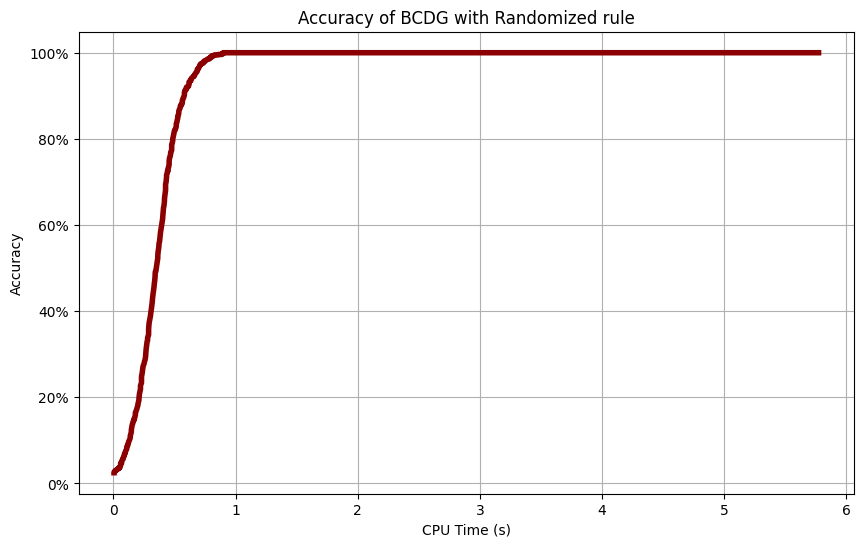

In [28]:
# Plot the accuracy of the model with respect to the CPU time
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_BCGD_R), accuracy_history_BCDG_R, 'darkred', linewidth=4, label='BCGD Randomized')
plt.grid()
plt.title("Accuracy of BCDG with Randomized rule")
plt.xlabel("CPU Time (s)")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.show()

## 6. BCGD with Gauss-Southwell rule

### 6.1. Algorithm

In [29]:
#  BCDG with Gauss-Southwell


def BCDG_GS(X, A, H, K, alpha, num_iterations, epsilon, j):

    # Store the history of the norm, time and cost to visualize the convergence
    norm_history = []
    time_history = []
    update_history = []

    # Compute the gradient of the loss function with respect to X
    grad = gradient(X, A, H, K)

    # Compute the norm of the columns of the gradient
    norm_grad_column = np.linalg.norm(grad, axis=0)

    # Initialize the iteration
    iteration = 0

    # Loop for a number of iterations
    while iteration < num_iterations and np.linalg.norm(grad) > epsilon:

        ## Step 1: start the timer
        start = time.time()


        ## Step 2: select a block using the Gauss-Southwell rule
        gs_index = np.argmax(norm_grad_column)
        
        ## Step 3: set the block of the gradient
        gs_gradient_block = grad[:, gs_index:gs_index+1]

        ## Step 4: compute the gradient of the block
        gs_gradient_block_new = gradient_block(X, A, H, K, gs_index)

        ## Step 5: compute the norm of the gradient of the block
        norm_grad_column[gs_index] = np.linalg.norm(gs_gradient_block_new)

        ## Step 6: update the block
        grad[:, gs_index:gs_index+1] = gs_gradient_block_new

        ## Step 7: update the parameters
        X = X - alpha * grad
       
        ## Step 8: end the timer
        end = time.time()

        ## Step 9: save the time to the history
        time_history.append(end - start)

        ## Step 10: save the norm to the history
        norm_history.append(np.linalg.norm(grad))     

        ## Step 11: store the current X
        update_history.append(X)    
        
        ## Step 12: increment the iteration
        iteration += 1
        
    return X, norm_history, time_history, update_history

# Run the BCDG algorithm
X_BCGD_GS, norm_history_BCGD_GS, time_history_BCGD_GS, update_history_BCGD_GS = BCDG_GS(X_train, A, H, K, alpha, num_iterations, epsilon, j)

# Print the accuracy on the training set
accuracy = compute_accuracy(X_BCGD_GS, A, B, False)
print('Accuracy on the training set:', accuracy * 100, '%')

Accuracy on the training set: 100.0 %


In [30]:
# Compute the cost history
cost_history_BCDG_GS = [compute_cost(X, A, H, M, K) for X in update_history_BCGD_GS]

In [31]:
# Compute the accuracy history
accuracy_history_BCDG_GS = [compute_accuracy(X, A, B, False) for X in update_history_BCGD_GS]

### 6.2. Visualization

#### 6.2.1. Convergence

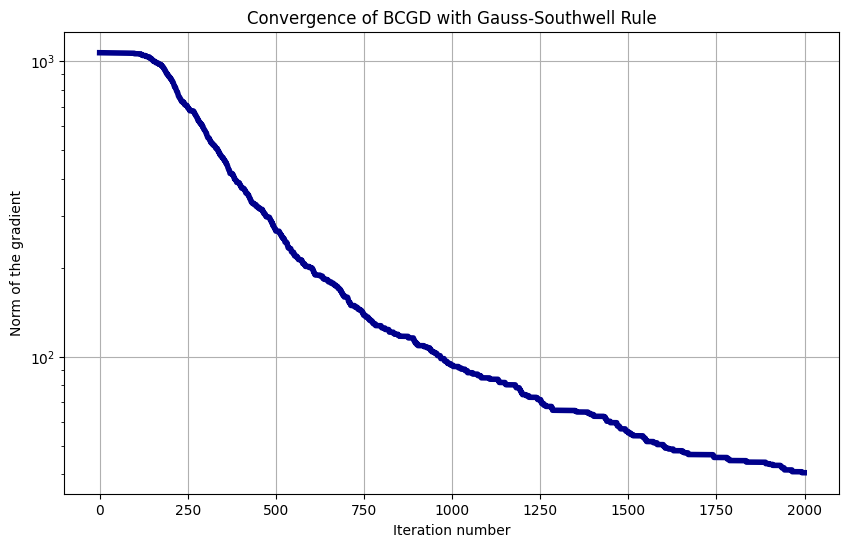

In [32]:
# Plot the convergence of the BCGD algorithm with respect to the number of iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(norm_history_BCGD_GS)), norm_history_BCGD_GS, 'darkblue', linewidth=4, label='BCGD Gauss-Southwell')
plt.grid()
plt.title("Convergence of BCGD with Gauss-Southwell Rule")
plt.xlabel("Iteration number")
plt.ylabel("Norm of the gradient")
plt.yscale('log')
plt.show()

#### 6.2.2. Accuracy

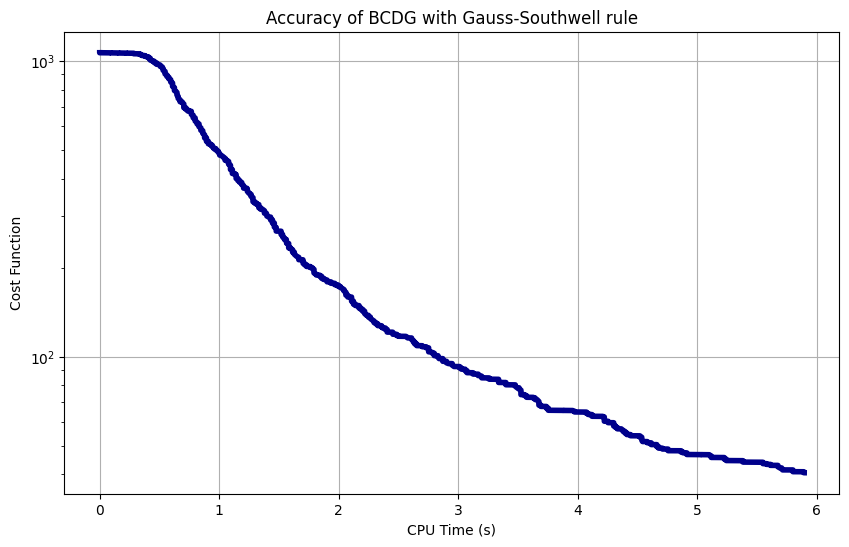

In [33]:
# Plot the cost function with respect to the CPU time
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_BCGD_GS), norm_history_BCGD_GS, 'darkblue', linewidth=4, label='BCGD Gauss-Southwell')
plt.grid()
plt.title("Accuracy of BCDG with Gauss-Southwell rule")
plt.xlabel("CPU Time (s)")
plt.ylabel("Cost Function")
plt.yscale('log')
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_15300\1619469473.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


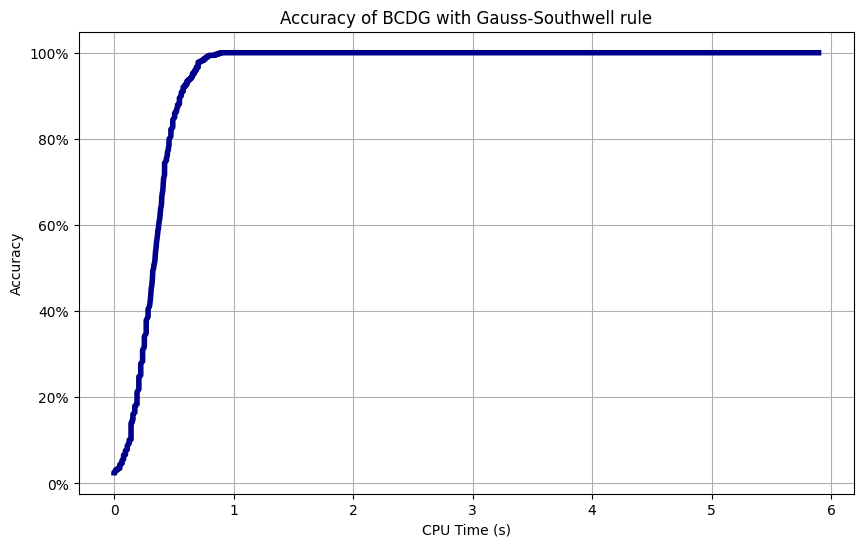

In [34]:
# Plot the accuracy of the model with respect to the CPU time
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_BCGD_GS), accuracy_history_BCDG_GS, 'darkblue', linewidth=4, label='BCGD Gauss-Southwell')
plt.grid()
plt.title("Accuracy of BCDG with Gauss-Southwell rule")
plt.xlabel("CPU Time (s)")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.show()

## 7. Real Dataset

In [35]:
# Download the dataset from the UCI repository
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80)  # Rerun the cell if the dataset is not downloaded

In [36]:
# Extract the features and the labels
DATASET_input = optical_recognition_of_handwritten_digits.data.features 
DATASET_label = optical_recognition_of_handwritten_digits.data.targets['class'] 

In [37]:
# Set the k equal to the number of labels
k = 10

# Split the data into a training set and a test set
A_train, A_test, B_train, B_test = train_test_split(DATASET_input, DATASET_label, test_size=0.2, random_state=seed)

### 7.1. Input $A$

In [38]:
# Convert the data to a numpy array
A_train = A_train.to_numpy(dtype=np.float64)
A_test = A_test.to_numpy(dtype=np.float64)


# Print the shape of the input data
print('Shape of A_train:', A_train.shape)
print('Shape of A_test:', A_test.shape)

Shape of A_train: (4496, 64)
Shape of A_test: (1124, 64)


In [39]:
# Rescale the input data
scaler = StandardScaler()
A_train = scaler.fit_transform(A_train)
A_test = scaler.fit_transform(A_test)

### 7.2. Parameters $X$

In [40]:

m_train = A_train.shape[0]  # number of samples in the training set
d_train = A_train.shape[1]  # number of features in the training set

m_test = A_test.shape[0]    # number of samples in the test set
d_test = A_test.shape[1]    # number of features in the test set

In [41]:
# Generate the features matrix with the Xavier initialization
X = np.random.randn(d_train, k) * np.sqrt(2 / d_train)

# Print the min and max values of X
print(np.min(X))
print(np.max(X))

# Print the shapes of the matrice
print('Shape of X:', X.shape)          # X is of shape (d, k)

-0.49256398779238797
0.5738955174343681
Shape of X: (64, 10)


### 7.3. Labels $B$

In [42]:
# Convert the labels to a numpy array
B_train = B_train.to_numpy(dtype=np.int64)
B_test = B_test.to_numpy(dtype=np.int64)

# Print the shape of the labels
print('Shape of B_train:', B_train.shape)
print('Shape of B_test:', B_test.shape)

Shape of B_train: (4496,)
Shape of B_test: (1124,)


### 7.4. One-Hot Encoding matrix $H$

In [43]:
# One-hot encoding the vector B
H_train = pd.get_dummies(B_train).to_numpy(dtype=np.int64)   # One-hot encoding the vector B_train
H_test = pd.get_dummies(B_test).to_numpy(dtype=np.int64)    # One-hot encoding the vector B_test

# Print the shapes of the matrice
print('Shape of H_train:', H_train.shape)       # H_train is of shape (m, k)
print('Shape of H_test:', H_test.shape)         # H_test is of shape (m, k)

Shape of H_train: (4496, 10)
Shape of H_test: (1124, 10)


### 7.5. Helper vector $M$ and $K$

In [44]:
# Compute a row vetor of ones
M_train = np.ones((1, m_train))
M_test = np.ones((1, m_test))

# Compute a column vector of ones
K = np.ones((k, 1))

### 7.6. Hyperparameters

In [45]:
# Set the learning rate
alpha = 1 / Lipschitz_constant(A_train)

# Set the number of iterations
num_iterations = 2000

# Set the tolerance
epsilon = 1e-6

# Set th number of blocks
j = k                                # each column of X is a block

### 7.7. Gradient Descent

In [46]:
# Run the gradient descent algorithm
X_GD_real, norm_history_GD_real, time_history_GD_real, update_history_GD_real = gradient_descent(X, A_train, H_train, K, alpha, num_iterations, epsilon)

In [47]:
# Print the accuracy on the test set
accuracy_test_GD = compute_accuracy(X_GD_real, A_test, B_test)
print('Accuracy on the test set:', accuracy_test_GD * 100, '%')

Accuracy on the test set: 93.77224199288257 %


In [48]:
# Compute the cost history on the test set
cost_history_GD_real = [compute_cost(X, A_test, H_test, M_test, K) for X in update_history_GD_real]

In [49]:
# Compute the accuracy history on the test set
accuracy_history_GD_real = [compute_accuracy(X, A_test, B_test) for X in update_history_GD_real]

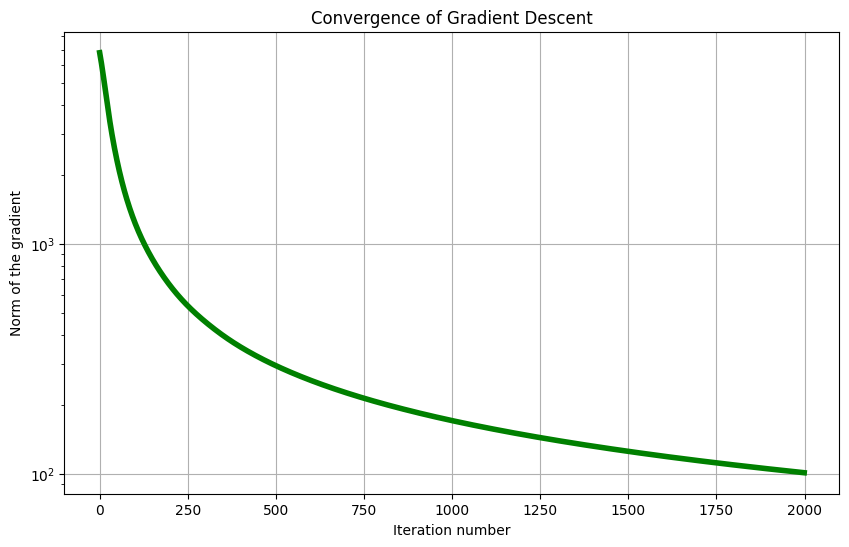

In [50]:
# Plot the convergence of the gradient descent algorithm with respect to the number of iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(norm_history_GD_real)), norm_history_GD_real, 'green', linewidth=4, label='Gradient Descent')
plt.grid()
plt.title("Convergence of Gradient Descent")
plt.xlabel("Iteration number")
plt.ylabel("Norm of the gradient")
plt.yscale('log')
plt.show()

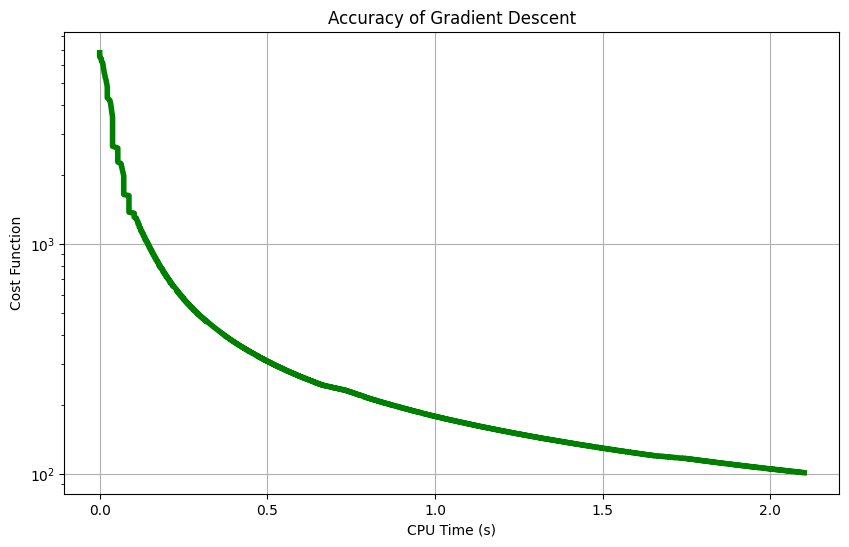

In [51]:
# Plot the convergence of the gradient descent algorithm with respect to the CPU time
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_GD_real), norm_history_GD_real, 'green', linewidth=4, label='Gradient Descent')
plt.grid()
plt.title("Accuracy of Gradient Descent")
plt.xlabel("CPU Time (s)")
plt.ylabel("Cost Function")
plt.yscale('log')
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_15300\503642403.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


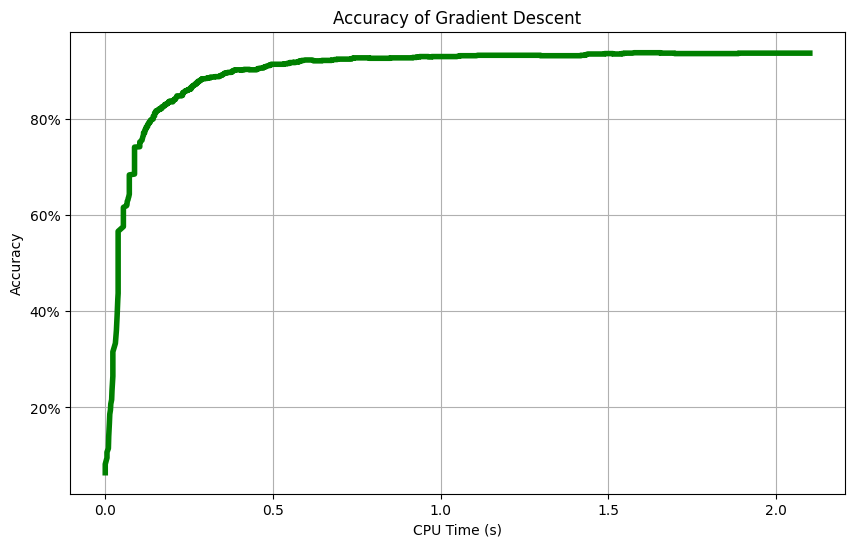

In [52]:
# Plot the accuracy with respect to the CPU time
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_GD_real), accuracy_history_GD_real, 'green', linewidth=4, label='Gradient Descent')
plt.grid()
plt.title("Accuracy of Gradient Descent")
plt.xlabel("CPU Time (s)")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.show()

### 7.8. BCDG with Randomized rule

In [53]:
# Run the BCDG algorithm with the randomized rule
X_BCGD_R_real, norm_history_BCGD_R_real, time_history_BCGD_R_real, update_history_BCGD_R_real = BCDG_randomized(X, A_train, H_train, K, alpha, num_iterations, epsilon, j)

# Print the accuracy on the test set
accuracy_test_BCGD_R = compute_accuracy(X_BCGD_R_real, A_test, B_test)
print('Accuracy on the test set:', accuracy_test_BCGD_R * 100, '%')

Accuracy on the test set: 93.23843416370107 %


In [54]:
# Compute the cost history on the test set
cost_history_BCDG_R_real = [compute_cost(X, A_test, H_test, M_test, K) for X in update_history_BCGD_R_real]

In [55]:
# Compute the accuracy history on the test set
accuracy_history_BCDG_R_real = [compute_accuracy(X, A_test, B_test) for X in update_history_BCGD_R_real]

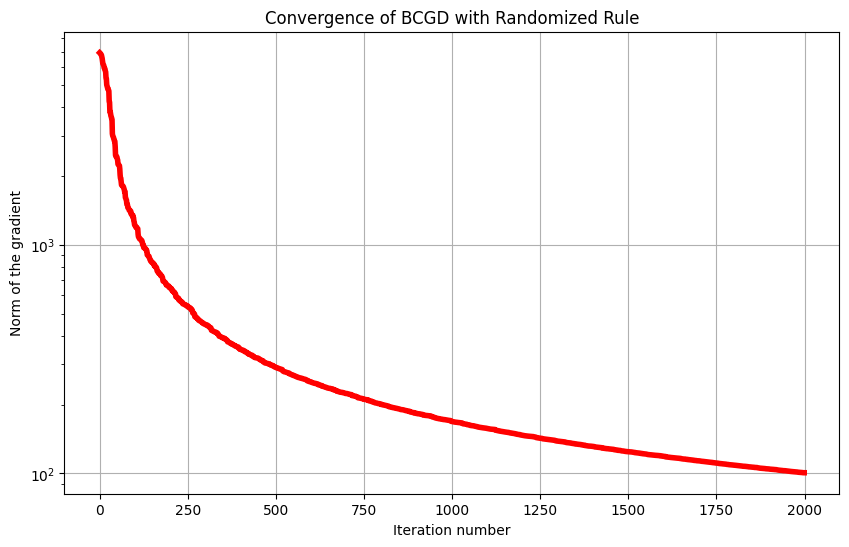

In [56]:
# Plot the convergence of the BCGD algorithm with respect to the number of iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(norm_history_BCGD_R_real)), norm_history_BCGD_R_real, 'red', linewidth=4, label='BCGD Randomized')
plt.grid()
plt.title("Convergence of BCGD with Randomized Rule")
plt.xlabel("Iteration number")
plt.ylabel("Norm of the gradient")
plt.yscale('log')
plt.show()

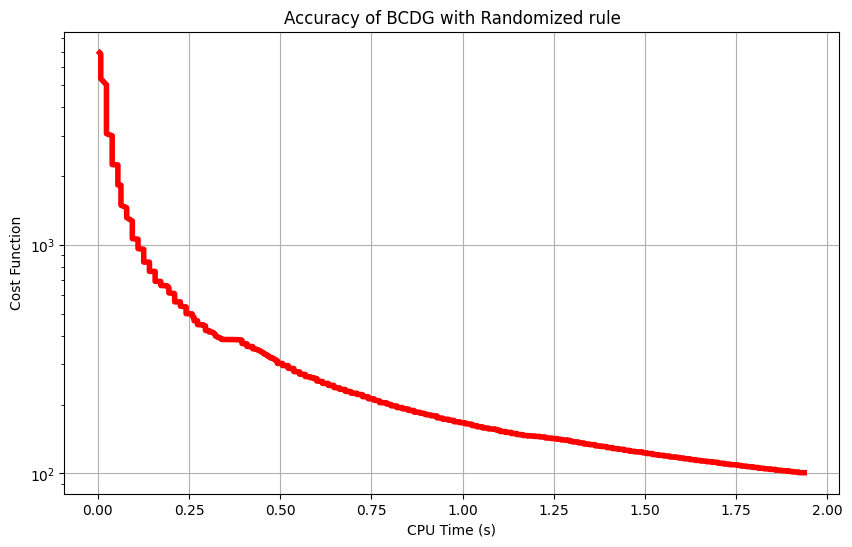

In [57]:
# Plot the convergence of the BCGD algorithm with respect to the CPU time
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_BCGD_R_real), norm_history_BCGD_R_real, 'red', linewidth=4, label='BCGD Randomized')
plt.grid()
plt.title("Accuracy of BCDG with Randomized rule")
plt.xlabel("CPU Time (s)")
plt.ylabel("Cost Function")
plt.yscale('log')
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_15300\897767868.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


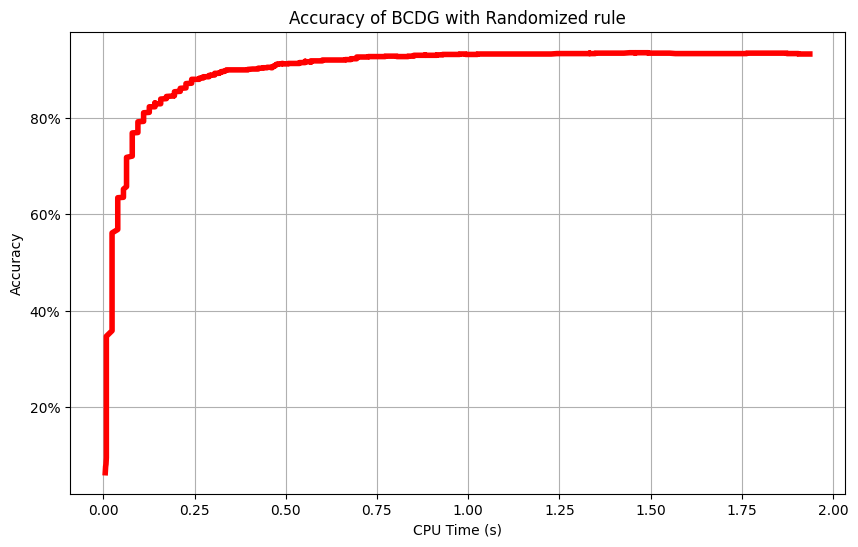

In [58]:
# Plot the accuracy with respect to the CPU time
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_BCGD_R_real), accuracy_history_BCDG_R_real, 'red', linewidth=4, label='BCGD Randomized')
plt.grid()
plt.title("Accuracy of BCDG with Randomized rule")
plt.xlabel("CPU Time (s)")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.show()

### 7.9. BCDG with Gauss-Southwell rule

In [59]:
# Run the BCDG algorithm with the Gauss-Southwell rule
X_BCGD_GS_real, norm_history_BCGD_GS_real, time_history_BCGD_GS_real, update_history_BCGD_GS_real = BCDG_GS(X, A_train, H_train, K, alpha, num_iterations, epsilon, j)

# Print the accuracy on the test set
accuracy_test_BCGD_GS = compute_accuracy(X_BCGD_GS_real, A_test, B_test)
print('Accuracy:', accuracy_test_BCGD_GS * 100, '%')

Accuracy: 92.61565836298932 %


In [60]:
# Compute the cost history on the test set
cost_history_BCDG_GS_real = [compute_cost(X, A_test, H_test, M_test, K) for X in update_history_BCGD_GS_real]


In [61]:
# Compute the accuracy history on the test set
accuracy_history_BCDG_GS_real = [compute_accuracy(X, A_test, B_test) for X in update_history_BCGD_GS_real]

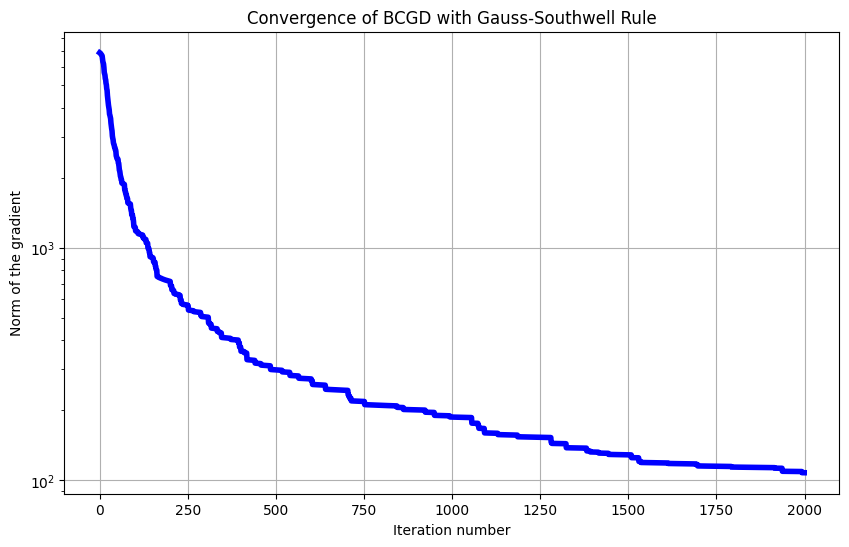

In [62]:
# Plot the convergence of the BCGD algorithm with respect to the number of iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(norm_history_BCGD_GS_real)), norm_history_BCGD_GS_real, 'blue', linewidth=4, label='BCGD Gauss-Southwell')
plt.grid()
plt.title("Convergence of BCGD with Gauss-Southwell Rule")
plt.xlabel("Iteration number")
plt.ylabel("Norm of the gradient")
plt.yscale('log')
plt.show()

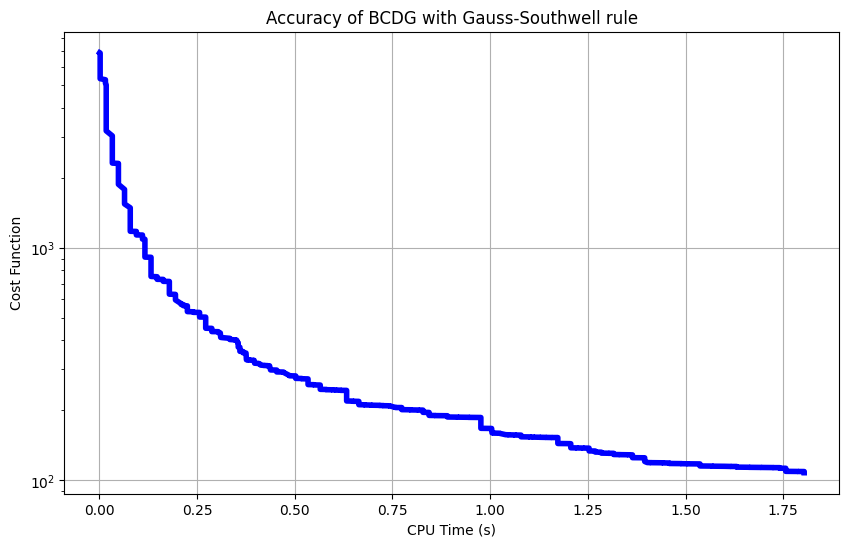

In [63]:
# Plot the convergence of the BCGD algorithm with respect to the CPU time
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_BCGD_GS_real), norm_history_BCGD_GS_real, 'blue', linewidth=4, label='BCGD Gauss-Southwell')
plt.grid()
plt.title("Accuracy of BCDG with Gauss-Southwell rule")
plt.xlabel("CPU Time (s)")
plt.ylabel("Cost Function")
plt.yscale('log')
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_15300\3748721620.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


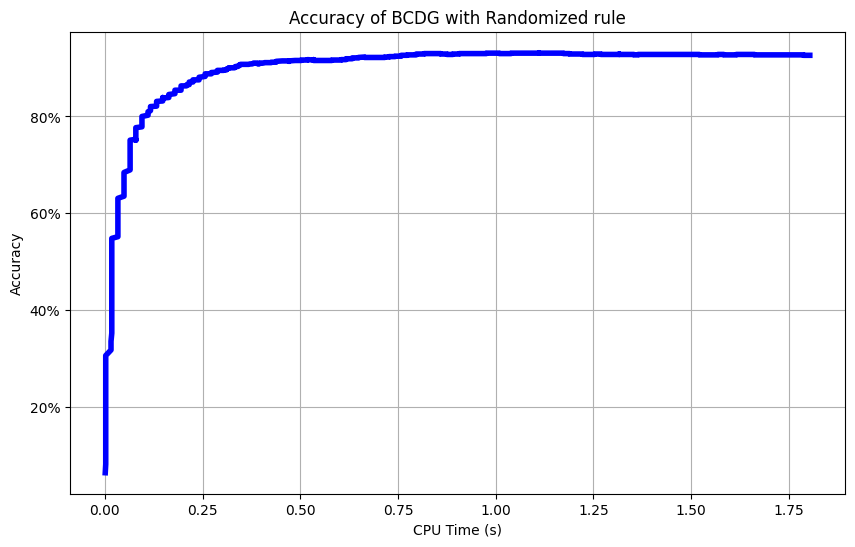

In [64]:
# Plot the accuracy with respect to the CPU time
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_BCGD_GS_real), accuracy_history_BCDG_GS_real, 'Blue', linewidth=4, label='BCGD Gauss-Southwell')
plt.grid()
plt.title("Accuracy of BCDG with Randomized rule")
plt.xlabel("CPU Time (s)")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.show()

## 8. Conclusion

### 8.1. Toy Dataset

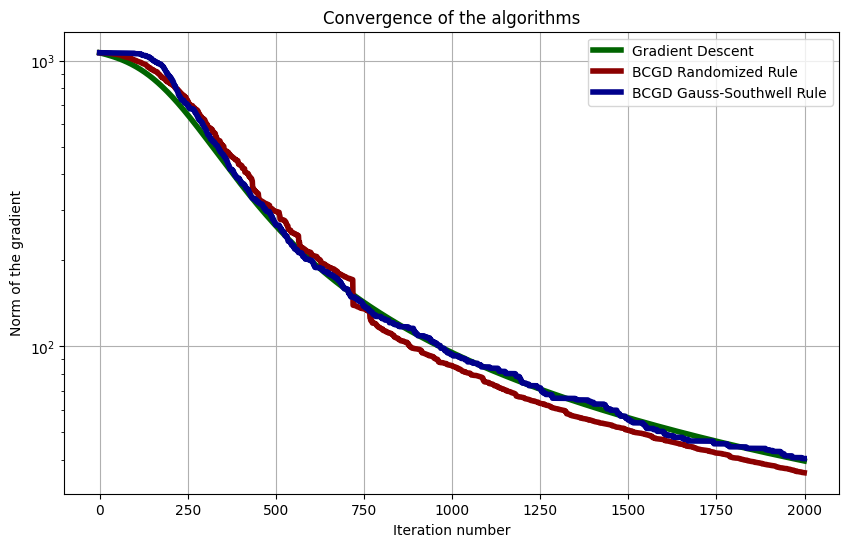

In [65]:
# Plot all the convergence plots together
plt.figure(figsize=(10, 6))
plt.plot(range(len(norm_history_GD)), norm_history_GD, 'darkgreen', linewidth=4, label='Gradient Descent')
plt.plot(range(len(norm_history_BCGD_R)), norm_history_BCGD_R, 'darkred', linewidth=4, label='BCGD Randomized Rule')
plt.plot(range(len(norm_history_BCGD_GS)), norm_history_BCGD_GS, 'darkblue', linewidth=4, label='BCGD Gauss-Southwell Rule')
plt.grid()
plt.title("Convergence of the algorithms")
plt.xlabel("Iteration number")
plt.ylabel("Norm of the gradient")
plt.yscale('log')
plt.legend()
plt.show()


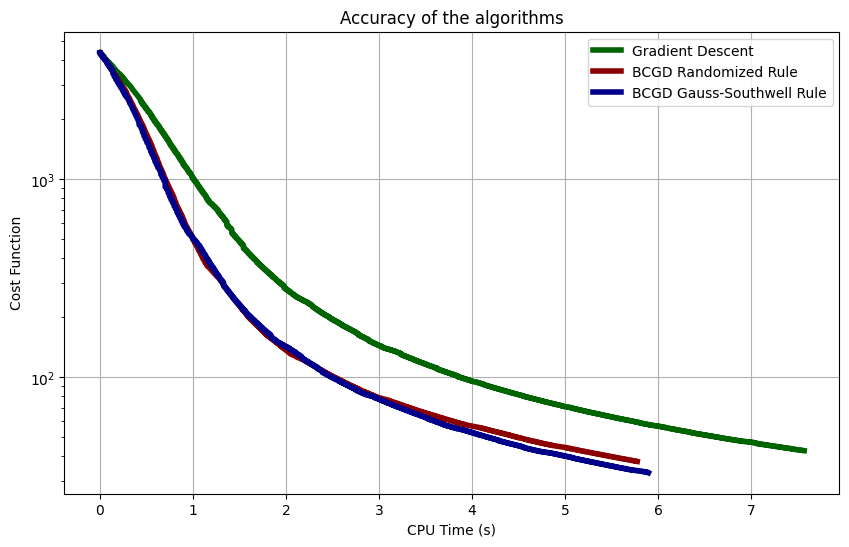

In [66]:
# Plot all the cost function plots together
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_GD), cost_history_GD, 'darkgreen', linewidth=4, label='Gradient Descent')
plt.plot(np.cumsum(time_history_BCGD_R), cost_history_BCDG_R, 'darkred', linewidth=4, label='BCGD Randomized Rule')
plt.plot(np.cumsum(time_history_BCGD_GS), cost_history_BCDG_GS, 'darkblue', linewidth=4, label='BCGD Gauss-Southwell Rule')
plt.grid()
plt.title("Accuracy of the algorithms")
plt.xlabel("CPU Time (s)")
plt.ylabel("Cost Function")
plt.yscale('log')
plt.legend()
plt.show()

###  8.2. Real Dataset

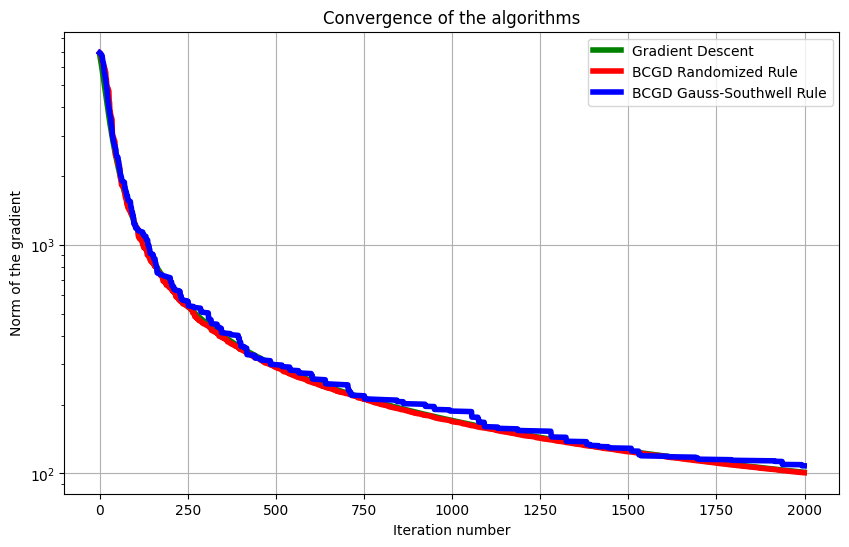

In [67]:
# Plot all the convergence plot together
plt.figure(figsize=(10, 6))
plt.plot(range(len(norm_history_GD_real)), norm_history_GD_real, 'green', linewidth=4, label='Gradient Descent')
plt.plot(range(len(norm_history_BCGD_R_real)), norm_history_BCGD_R_real, 'red', linewidth=4, label='BCGD Randomized Rule')
plt.plot(range(len(norm_history_BCGD_GS_real)), norm_history_BCGD_GS_real, 'blue', linewidth=4, label='BCGD Gauss-Southwell Rule')
plt.grid()
plt.title("Convergence of the algorithms")
plt.xlabel("Iteration number")
plt.ylabel("Norm of the gradient")
plt.yscale('log')
plt.legend()
plt.show()

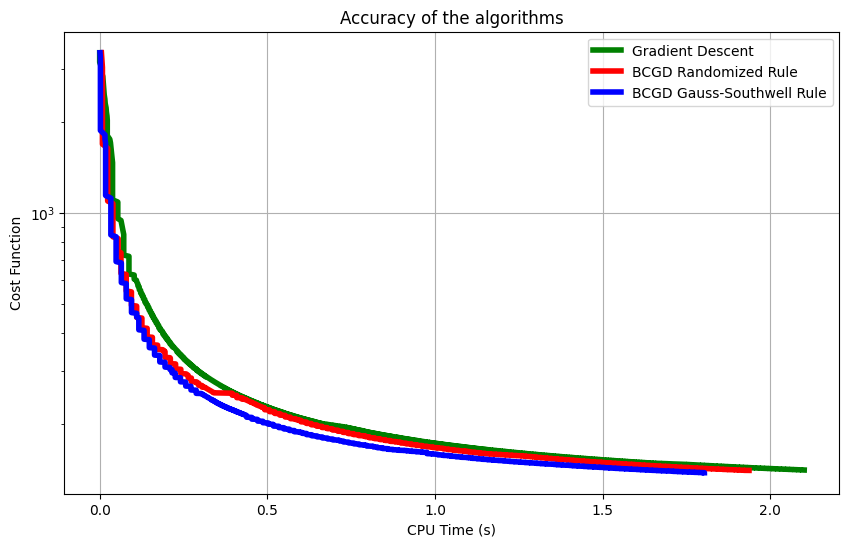

In [68]:
# Plot all the cost function plots together
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_GD_real), cost_history_GD_real, 'green', linewidth=4, label='Gradient Descent')
plt.plot(np.cumsum(time_history_BCGD_R_real), cost_history_BCDG_R_real, 'red', linewidth=4, label='BCGD Randomized Rule')
plt.plot(np.cumsum(time_history_BCGD_GS_real), cost_history_BCDG_GS_real, 'blue', linewidth=4, label='BCGD Gauss-Southwell Rule')
plt.grid()
plt.title("Accuracy of the algorithms")
plt.xlabel("CPU Time (s)")
plt.ylabel("Cost Function")
plt.yscale('log')
plt.legend()
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_15300\1045009608.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


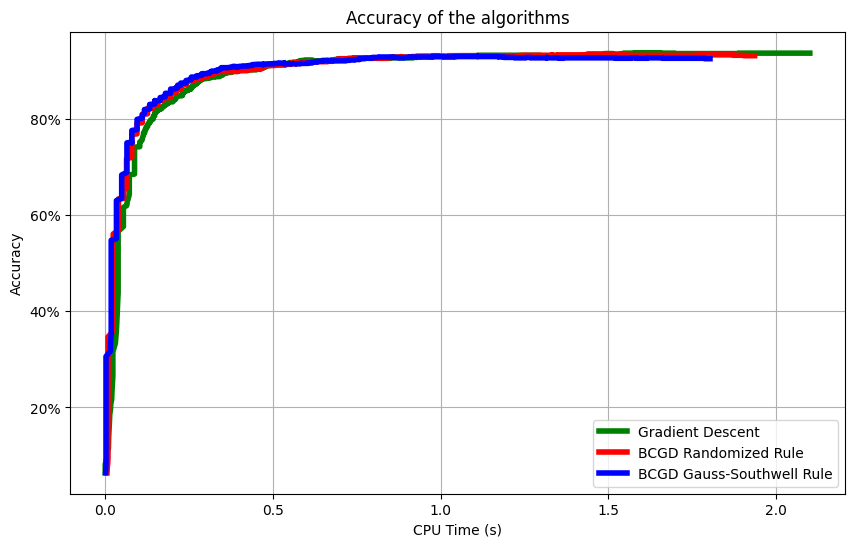

In [69]:
# Plot all the accuracy plots together
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(time_history_GD_real), accuracy_history_GD_real, 'green', linewidth=4, label='Gradient Descent')
plt.plot(np.cumsum(time_history_BCGD_R_real), accuracy_history_BCDG_R_real, 'red', linewidth=4, label='BCGD Randomized Rule')
plt.plot(np.cumsum(time_history_BCGD_GS_real), accuracy_history_BCDG_GS_real, 'blue', linewidth=4, label='BCGD Gauss-Southwell Rule')
plt.grid()
plt.title("Accuracy of the algorithms")
plt.xlabel("CPU Time (s)")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

In [70]:
# Print the accuracy of the algorithms on the test set
print('Accuracy on the test set:')
print('Gradient Descent:', accuracy_test_GD * 100, '%')
print('BCGD Randomized Rule:', accuracy_test_BCGD_R * 100, '%')
print('BCGD Gauss-Southwell Rule:', accuracy_test_BCGD_GS * 100, '%')

Accuracy on the test set:
Gradient Descent: 93.77224199288257 %
BCGD Randomized Rule: 93.23843416370107 %
BCGD Gauss-Southwell Rule: 92.61565836298932 %
